## Problem Statement:

- Heart disease remains a major global health concern.
- Our study aims to identify the best model to predict whether a person has a heart attack based on the attributes. By examining demographic and clinical variables such as age, sex, chest pain type, and cholesterol, we seek actionable insights to improve risk assessment and intervention strategies.


## Data Description:

- This heart disease dataset combines 5 previously separate datasets — Cleveland, Hungarian, Switzerland, Long Beach VA, and Statlog (Heart)—into one comprehensive collection.
- It contains 1190 instances with 11 common features, making it the largest heart disease dataset available for research. 
- By analyzing these datasets, it aims to facilitate research on coronary artery disease (CAD) to improve clinical diagnosis and early treatment.

| Sr. # | Attribute                                | Unit             | Data Type   |
|-------|------------------------------------------|------------------|-------------|
| 1     | Age                                      | In Years         | Numeric     |
| 2     | Sex                                      | 1,0              | Categorical |
| 3     | Chest pain type                          | 1,2,3,4          | Categorical |
| 4     | Resting blood pressure                   | In mm Hg         | Numeric     |
| 5     | Cholesterol                              | In mg/dl         | Numeric     |
| 6     | Fasting blood sugar                      | 1,0 > 120 mg/dl  | Categorical |
| 7     | Resting electrocardiogram results        | 0,1,2            | Categorical |
| 8     | Maximum heart rate achieved              | 71 - 202         | Numeric     |
| 9     | Exercise induced angina                  | 0,1              | Categorical |
| 10    | Oldpeak = ST depression                  | Numeric          | Numeric     |
| 11    | The slope of the peak exercise ST segment| 0,1,2            | Categorical |
| 12    | Class                                    | 0,1              | Categorical |


In [2]:
# Installing xgboost model in the environment
!pip install xgboost

  Obtaining dependency information for xgboost from https://files.pythonhosted.org/packages/24/ec/ad387100fa3cc2b9b81af0829b5ecfe75ec5bb19dd7c19d4fea06fb81802/xgboost-2.0.3-py3-none-win_amd64.whl.metadata
   ---------------------------------------- 0.0/99.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/99.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/99.8 MB 435.7 kB/s eta 0:03:49
   ---------------------------------------- 0.1/99.8 MB 651.6 kB/s eta 0:02:33
   ---------------------------------------- 0.3/99.8 MB 2.3 MB/s eta 0:00:45
   ---------------------------------------- 1.1/99.8 MB 5.2 MB/s eta 0:00:19
    --------------------------------------- 1.5/99.8 MB 6.0 MB/s eta 0:00:17
    --------------------------------------- 2.2/99.8 MB 7.2 MB/s eta 0:00:14
   - -------------------------------------- 2.5/99.8 MB 7.4 MB/s eta 0:00:14
   - -------------------------------------- 3.9/99.8 MB 9.8 MB/s eta 0:00:10
   - ------------------------------

KeyError: 'resting bp s'

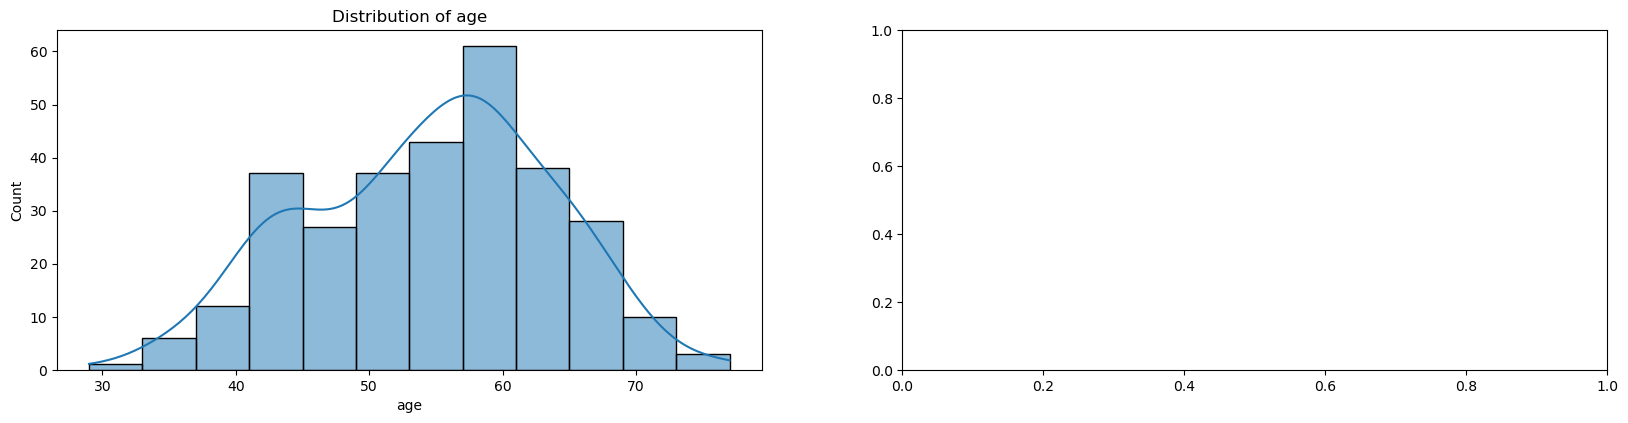

In [3]:
# Installing & Importing the libraries:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score
from xgboost import XGBClassifier
from scipy.stats import ttest_rel

# Load the dataset
heart_disease_data = pd.read_csv('heart.csv')
heart_disease_data.head()

# Summary statistics
summary_statistics = heart_disease_data.describe()

# Visualization
plt.figure(figsize=(20, 15))

# Histograms for numeric attributes
for i, column in enumerate(['age', 'resting bp s', 'cholesterol', 'max heart rate', 'oldpeak'], start=1):
    plt.subplot(3, 2, i)
    sns.histplot(heart_disease_data[column], kde=True)
    plt.title(f'Distribution of {column}')

plt.tight_layout()
plt.show()

summary_statistics

## Descriptive Statistics:
- **Age:** The mean age is around 53.7 years, with a standard deviation of approximately 9.36 years. The distribution appears slightly left-skewed (negative skewness) as the mean is slightly less than the median.
- **Resting Blood Pressure (BP):** The mean resting blood pressure is around 132.15 mm Hg, with a standard deviation of approximately 18.37 mm Hg. The distribution seems slightly right-skewed (positive skewness).
- **Cholesterol:** The mean cholesterol level is around 210.36 mg/dl, with a standard deviation of approximately 101.42 mg/dl. The distribution appears to be right-skewed.
- **Fasting Blood Sugar:** This binary categorical variable (0 or 1) indicates whether fasting blood sugar is greater than 120 mg/dl. The mean value suggests that approximately 21.34% of the individuals have fasting blood sugar greater than 120 mg/dl.
- **Maximum Heart Rate Achieved:** The mean maximum heart rate achieved is around 139.73 beats per minute, with a standard deviation of approximately 25.52 beats per minute. The distribution appears to be slightly left-skewed.
- **Exercise Induced Angina:** The mean value suggests that approximately 38.74% of the individuals experienced exercise-induced angina.
- **Target (Class):** This binary categorical variable (0 or 1) represents the presence of heart disease. The mean value suggests that approximately 52.86% of the individuals have heart disease.

##  Treating Missing values and '0' values:
- It seems that initially, there were instances where both blood pressure (BP) and cholesterol values were recorded as 0, which is not physiologically possible.
- To address this issue and make the data more reliable and usable, imputation was performed.
- After imputation, the median values for blood pressure and cholesterol were calculated.
- The median blood pressure after imputation is 130.0, and the median cholesterol level after imputation is approximately 245.91.
- Imputation with the median values helps to ensure that the dataset is more accurate and representative for analysis or further processing.

In [3]:
# Check for zero values in 'resting bp s' and 'cholesterol'
zeros_bp = (heart_disease_data['resting bp s'] == 0).sum()
zeros_chol = (heart_disease_data['cholesterol'] == 0).sum()

# Replace zero values with the mean of the respective columns.
# Have to try with Median as well
median_bp = heart_disease_data['resting bp s'][heart_disease_data['resting bp s'] > 0].median()
median_chol = heart_disease_data['cholesterol'][heart_disease_data['cholesterol'] > 0].median()

heart_disease_data['resting bp s'] = heart_disease_data['resting bp s'].replace(0, median_bp)
heart_disease_data['cholesterol'] = heart_disease_data['cholesterol'].replace(0, median_chol)

# Check if successful
post_imputation_bp_median = heart_disease_data['resting bp s'].median()
post_imputation_chol_median = heart_disease_data['cholesterol'].median()

{
    "zeros_in_bp_before": zeros_bp,
    "zeros_in_chol_before": zeros_chol,
    "post_imputation_bp_median": post_imputation_bp_median,
    "post_imputation_chol_median": post_imputation_chol_median
}

{'zeros_in_bp_before': 1,
 'zeros_in_chol_before': 172,
 'post_imputation_bp_median': 130.0,
 'post_imputation_chol_median': 240.0}

In [4]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# Checking for multicollinearity using Variance Inflation Factor (VIF)
data_vif = heart_disease_data[['age', 'sex', 'chest pain type', 'resting bp s', 'cholesterol', 
                 'fasting blood sugar', 'resting ecg', 'max heart rate', 
                 'exercise angina', 'oldpeak', 'ST slope']]
data_vif = add_constant(data_vif)

# Calculating VIF for each variable
vif_data = pd.DataFrame()
vif_data["Variable"] = data_vif.columns
vif_data["VIF"] = [variance_inflation_factor(data_vif.values, i) for i in range(data_vif.shape[1])]

# Display the VIF values
vif_data

,Variable,VIF
0,const,213.883477
1,age,1.350395
2,sex,1.097358
3,chest pain type,1.284312
4,resting bp s,1.117386
5,cholesterol,1.052068
6,fasting blood sugar,1.067596
7,resting ecg,1.083017
8,max heart rate,1.481465
9,exercise angina,1.483366


In [14]:
# Prepare data
X = heart_disease_data.drop('target', axis=1)
y = heart_disease_data['target']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [16]:
# Cross-Validation Scores
log_reg_scores = cross_val_score(log_reg, X_train_scaled, y_train, cv=5, scoring='roc_auc')
rf_scores = cross_val_score(rf_grid_search.best_estimator_, X_train, y_train, cv=5, scoring='roc_auc')
xgb_scores = cross_val_score(xgb_grid_search.best_estimator_, X_train, y_train, cv=5, scoring='roc_auc')

In [17]:
# Display cross-validation results
print("Logistic Regression CV AUC:", np.mean(log_reg_scores), "±", np.std(log_reg_scores))
print("Random Forest CV AUC:", np.mean(rf_scores), "±", np.std(rf_scores))
print("XGBoost CV AUC:", np.mean(xgb_scores), "±", np.std(xgb_scores))

Logistic Regression CV AUC: 0.9005258963258964 ± 0.02507196849825056
Random Forest CV AUC: 0.9520363192363192 ± 0.012448247839844351
XGBoost CV AUC: 0.9434942612942614 ± 0.010841508406181038


In [18]:
# Logistic Regression
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_scaled, y_train)
y_pred_log = log_reg.predict(X_test)

/Users/nustanishant/anaconda3/lib/python3.11/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


In [19]:
# Random Forest Model
rf_model = RandomForestClassifier(random_state=42)
rf_param_grid = {'n_estimators': [50, 100, 150], 'max_depth': [10, 20, 30]}
rf_grid_search = GridSearchCV(rf_model, param_grid=rf_param_grid, cv=5)
rf_grid_search.fit(X_train_scaled, y_train)
best_rf_model = rf_grid_search.best_estimator_

In [20]:
# XGBoost Model
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_param_grid = {'n_estimators': [100, 200, 300], 'max_depth': [3, 4, 5]}
xgb_grid_search = GridSearchCV(xgb_model, param_grid=xgb_param_grid, cv=5)
xgb_grid_search.fit(X_train_scaled, y_train)
best_xgb_model = xgb_grid_search.best_estimator_

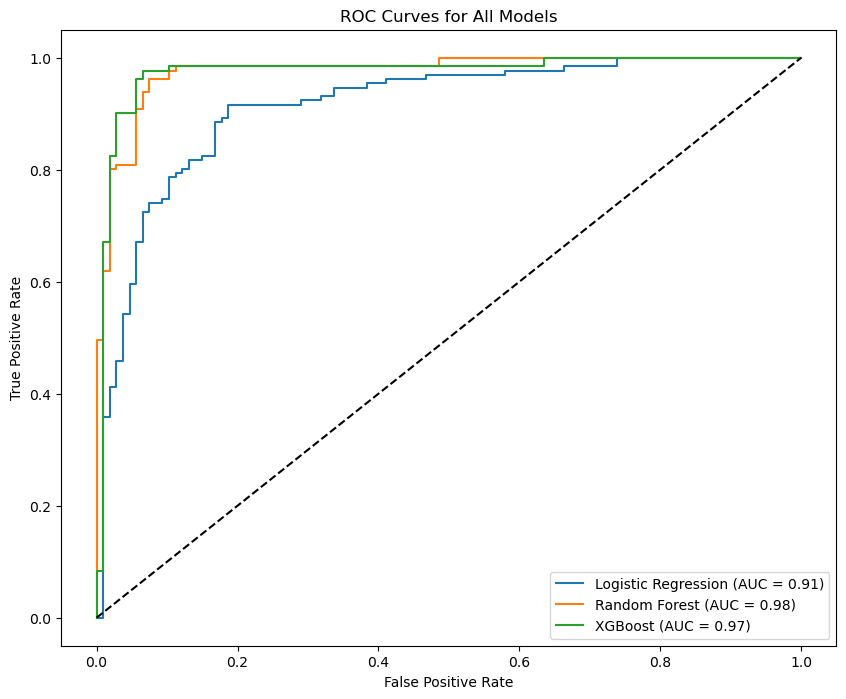

In [21]:
# ROC Curves
fpr_logreg, tpr_logreg, _ = roc_curve(y_test, log_reg.predict_proba(X_test_scaled)[:, 1])
fpr_rf, tpr_rf, _ = roc_curve(y_test, best_rf_model.predict_proba(X_test_scaled)[:, 1])
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, best_xgb_model.predict_proba(X_test_scaled)[:, 1])

# Plot ROC Curves
plt.figure(figsize=(10, 8))
plt.plot(fpr_logreg, tpr_logreg, label=f'Logistic Regression (AUC = {roc_auc_score(y_test, log_reg.predict_proba(X_test_scaled)[:, 1]):.2f})')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_score(y_test, best_rf_model.predict_proba(X_test_scaled)[:, 1]):.2f})')
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {roc_auc_score(y_test, best_xgb_model.predict_proba(X_test_scaled)[:, 1]):.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for All Models')
plt.legend(loc='lower right')
plt.show()

In [22]:
# Performance Metrics Matrix
models = ['Logistic Regression', 'Random Forest', 'XGBoost']
best_models = [log_reg, best_rf_model, best_xgb_model]
metrics_data = []

for model, best_model in zip(models, best_models):
    y_pred = best_model.predict(X_test_scaled)
    y_pred_proba = best_model.predict_proba(X_test_scaled)[:, 1]
    metrics_data.append({
        'Model': model,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'ROC AUC': roc_auc_score(y_test, y_pred_proba)
    })

metrics = pd.DataFrame(metrics_data)
round(metrics,3)

,Model,Accuracy,Precision,Recall,ROC AUC
0,Logistic Regression,0.857,0.865,0.878,0.914
1,Random Forest,0.933,0.920,0.962,0.976
2,XGBoost,0.954,0.948,0.969,0.975
